# Хакатон Сбербанка и СберТеха по машинному обучению

## Участник  - Александр Ляшук
### НИУ ВШЭ НН
#### 4 курс, Факультет Информатики, Математики и Компьтерных Наук

# Overview

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
from gensim import models

import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score,accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer

from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

import warnings
warnings.simplefilter('ignore')

from additions.sber import *
from additions.attention_layer import *

Using TensorFlow backend.


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Input, Dot
from keras.layers.merge import Concatenate
from keras import regularizers
from attention_layer import *

# scores = []

In [3]:
train_data = pd.read_csv('data/app_review_rating_train.csv')
test_data = pd.read_csv('data/app_review_rating_test.csv')

In [4]:
train_data.head()

,Date,AppName,Language,Version,Rating,Title,Review
0,2017-11-06,Сбербанк Онлайн,ru,8.3.0,3,Вылетает исправьте,После очередного обновления не работает вылета...
1,2017-06-23,Сбербанк Онлайн,ru,8.1.0,5,Очень удобно!,"МЕГА удобно и функционально, все отлично работ..."
2,2017-04-12,Сбербанк Онлайн,ru,8.0.2,3,Бесконтактная оплата,Добавьте VISA PAY!!!!!!
3,2017-07-29,Сбербанк Онлайн,ru,8.1.0,5,Все работает без проблем.,Все хорошо
4,2016-11-28,Сбербанк Онлайн,ru,7.4.4,5,Круто мне нравится ?,Круто удобная связь?


В данных есть дата публикации отзыва, название приложения, его версия, язык, заголовок, отзыв и оценка.

In [9]:
pd.DataFrame(train_data['Rating'].value_counts())

,Rating
5,51730
1,11696
4,6769
3,3616
2,2470


In [5]:
pd.DataFrame(train_data['AppName'].value_counts())

,AppName
Сбербанк Онлайн,72623
Сбербанк Бизнес Онлайн,2108
Спасибо от Сбербанка,1525
«Взрослые и дети» от Сбербанка,22
Сбербанк IR,3


Видно, что отзывов по Сбербанку Онлайн намного больше, чем по другим продуктам, по которым отзывов гораздо меньше (> 70 000 и < 2100), поэтому использовать эту информация в качестве дополнительного признака я не стал. Можно, конечно, обучить несколько моделей по каждому продукту, но данных для обучения очень мало, модель либо не сможет восстановить искомую зависимость, либо переобучится.

In [6]:
pd.DataFrame(train_data['Language'].value_counts())

,Language
ru,75893
us,340
gb,32
au,9
es,7


Большинство отзывов на русском языке

In [7]:
pd.DataFrame(train_data.groupby('Version')['Rating'].mean().head())

,Rating
Version,
0,4.602052
1.0,2.665595
1.0.120,2.361111
1.0.141,1.678571
1.0.150,2.000000


Можно было бы использовать среднюю оценку по версии или по году и месяцу, но так как целью является решение бизнес задачи и реализация прототипа, по которому можно было бы оценить, доволен пользователь продуктом или нет, то лучше это не использовать :)

In [8]:
train_data['year'] = train_data['Date'].apply(make_year)
train_data['month'] = train_data['Date'].apply(make_month)
train_data['day'] = train_data['Date'].apply(make_day)

tmp = pd.DataFrame(train_data.groupby(['year','month'])['Rating'].mean())
tmp = tmp.unstack(level=0)
tmp.columns = [2012,2013,2014,2015,2016,2017]

train_data.drop(['year','month', 'day'], inplace=True, axis = 1)

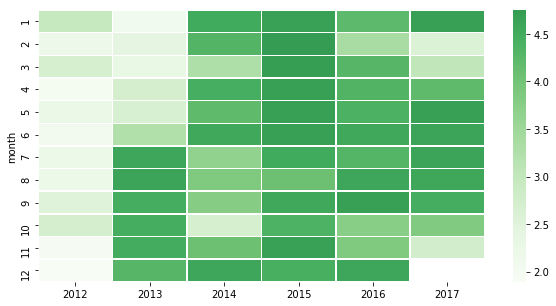

In [9]:
sns.heatmap(tmp,cmap = 'Greens',linewidths=.5,center=4)

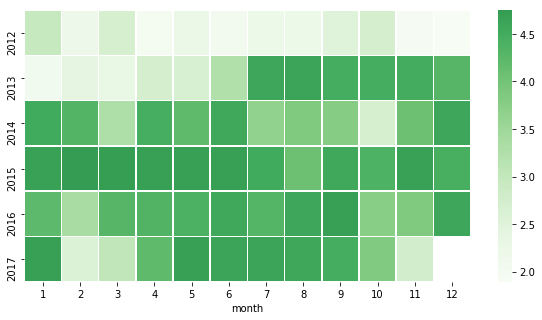

In [10]:
sns.heatmap(tmp.T,cmap = 'Greens',linewidths=.5,center=4)

Видно, что в периоды 2012 - 2013 года, пользователи были недовольны продуктами Сбербанка, а самый удачный год - 2015 - наибольшее количество положительных оценок. К концу 2017 видно, что пользователи недовольны новыми версиями приложений. 

## WordClouds каждого класса

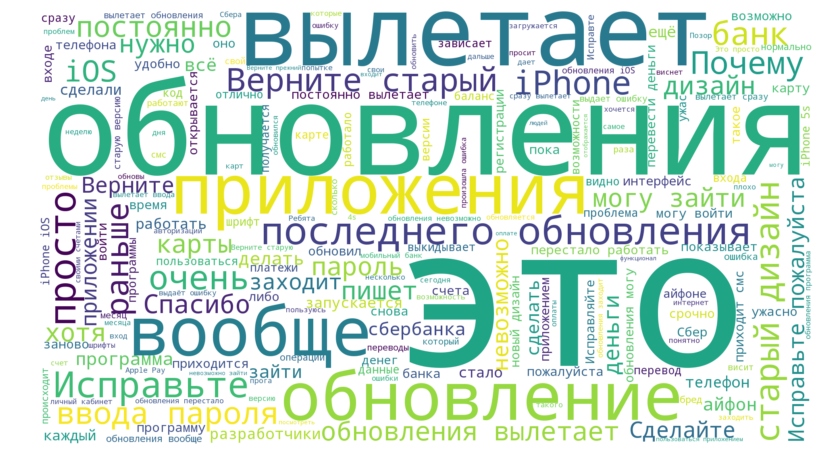

In [11]:
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')
stopwords += ['приложение', 'сбербанк','онлайн','работает']

text = str()
for i in train_data[train_data['Rating'] == 1]['Review']:
    text += str(i)

wc = WordCloud(background_color="white",
               stopwords=stopwords, width = 1920,height = 1080)
wc.generate(text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

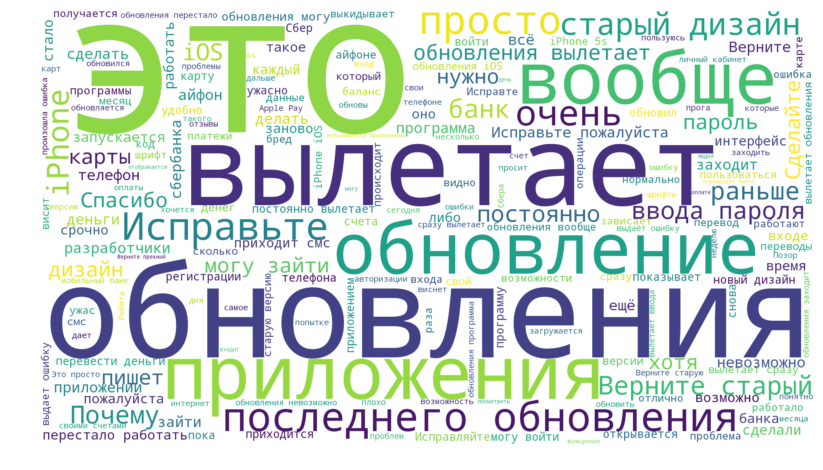

In [25]:
text = str()
for i in train_data[train_data['Rating'] == 1]['Review']:
    text += str(i)

wc = WordCloud(background_color="white",
               stopwords=stopwords, width = 1920,height = 1080)
wc.generate(text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

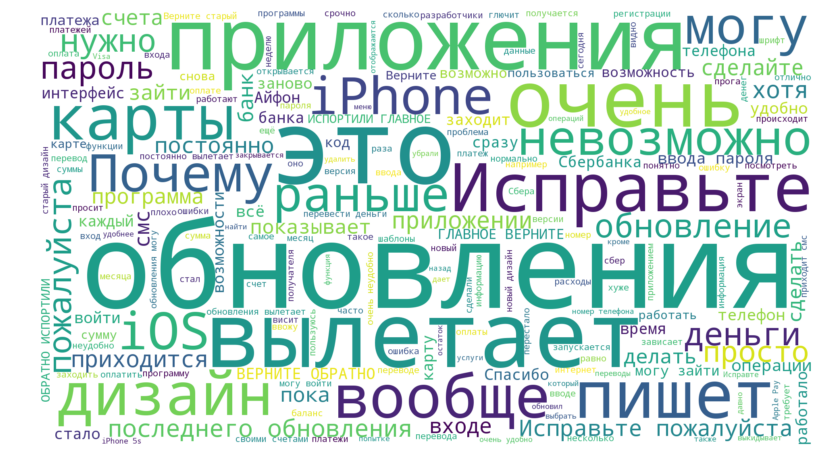

In [26]:
text = str()
for i in train_data[train_data['Rating'] == 2]['Review']:
    text += str(i)

wc = WordCloud(background_color="white",
               stopwords=stopwords, width = 1920,height = 1080)
wc.generate(text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

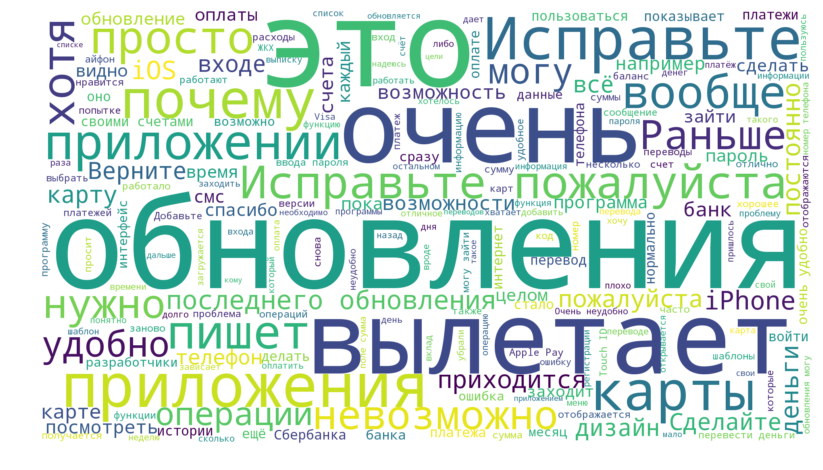

In [27]:
text = str()
for i in train_data[train_data['Rating'] == 3]['Review']:
    text += str(i)

wc = WordCloud(background_color="white",
               stopwords=stopwords, width = 1920,height = 1080)
wc.generate(text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

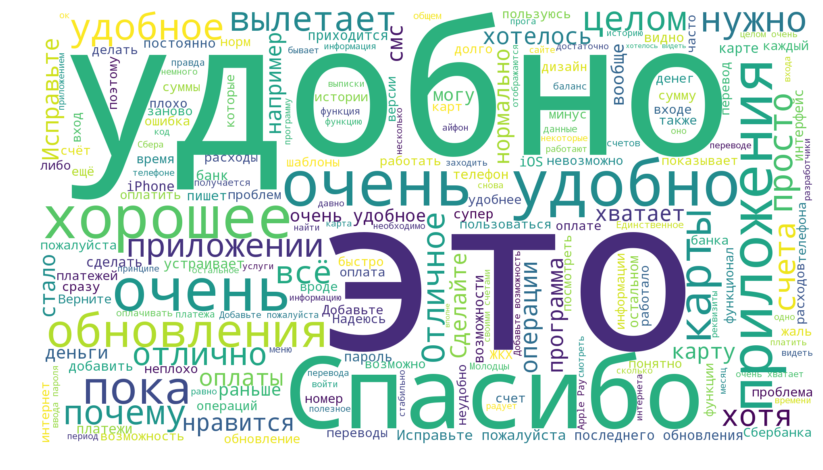

In [28]:
text = str()
for i in train_data[train_data['Rating'] == 4]['Review']:
    text += str(i)

wc = WordCloud(background_color="white",
               stopwords=stopwords, width = 1920,height = 1080)
wc.generate(text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

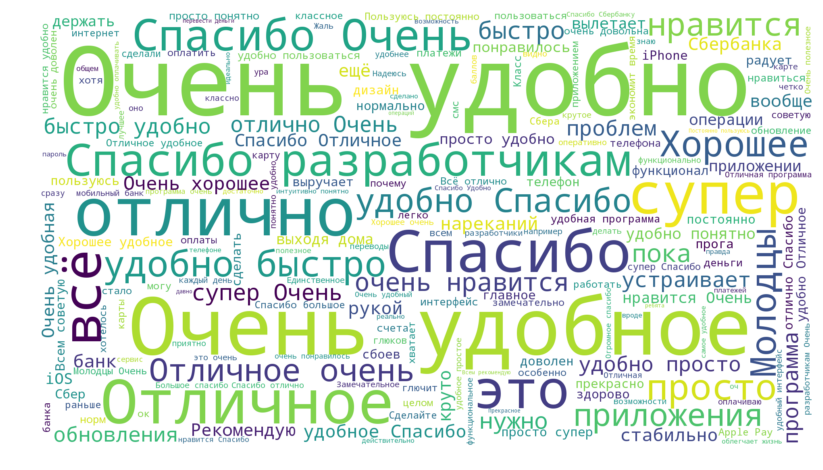

In [29]:
text = str()
for i in train_data[train_data['Rating'] == 5]['Review']:
    text += str(i)

wc = WordCloud(background_color="white",
               stopwords=stopwords, width = 1920,height = 1080)
wc.generate(text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Отлично видно, что оценки 4 и 5 ставят пользователи, которые очень довольны приложением, но если пользователь ставит 3 - то он очень недоволен, нет плавного перехода, то есть 1,2,3 - недовольны работоспособностью приложения после обновления.

## Кластеризация отзывов

In [13]:
# together
X_train = list()
for i in range(0,len(train_data)):
    X_train.append(str(train_data['Title'].iloc[i]) + ' ' + str(train_data['Review'].iloc[i]))
    
vectorizer = CountVectorizer(stop_words=stopwords)
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', '... 'им', 'более', 'всегда', 'конечно', 'всю', 'между', 'приложение', 'сбербанк', 'онлайн', 'работает'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [ ]:
lda = LatentDirichletAllocation(n_topics=2)
lda.fit(vectorizer.transform(X_train))
pyLDAvis.sklearn.prepare(lda, vectorizer.transform(X_train), vectorizer)

In [18]:
import json

In [20]:
with open('results/scores.txt') as file:
    js = json.load(file)

In [27]:
print(js[3]['report'])

             precision    recall  f1-score   support

          1       0.60      0.91      0.72      1169
          2       0.00      0.00      0.00       247
          3       0.29      0.07      0.11       361
          4       0.44      0.23      0.30       676
          5       0.91      0.95      0.93      5173

avg / total       0.76      0.81      0.78      7626



# Models

Уберем из данных дату, приложение, язык и версию и предобработаем (sper.py - регулярка для чистки) текст.  
Можно попробовать лемматизацию слов, но так как "вылетало" и "вылетает" это не одно и то же, что и "вылетать" как в случае с лемматизацией, поэтому результаты хуже, это будет видно ниже.

In [4]:
train_data.drop(['Date', 'AppName', 'Language', 'Version'], axis = 1, inplace = True)
train_data['Review'] = train_data['Review'].map(preprocess)
train_data['Title'] = train_data['Title'].map(preprocess)

# m = Mystem()
# train_data['Review'] = train_data['Review'].map(lambda x: ''.join(m.lemmatize(str(x))[:-1]))
# train_data['Title'] = train_data['Title'].map(lambda x: ''.join(m.lemmatize(str(x))[:-1]))

Далее необходимо сделать валидационную выборку, но так как классы несбалансированны, возьмем по 10% данных из каждого класса.

In [5]:
val_data = pd.DataFrame()
for i in range(1,6):
    val_data = val_data.append(train_data[train_data['Rating'] == i].sample(int(train_data['Rating'].value_counts().loc[i] * 0.1),random_state = 7))
train_data.drop(val_data.index,inplace=True)

### Ridge
Подбор параметра регуляризации и тесирование на валидационной выборке метриками accuracy, f1 (macro) score. 

In [ ]:
# together
X_train = list()
X_val = list()
for i in range(0,len(train_data)):
    X_train.append(str(train_data['Title'].iloc[i]) + ' ' + str(train_data['Review'].iloc[i]))
    
for i in range(0,len(val_data)):
    X_val.append(str(val_data['Title'].iloc[i]) + ' ' + str(val_data['Review'].iloc[i]))
    
vectorizer = CountVectorizer(ngram_range=(1,2))

X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

y_train = list(train_data['Rating'])
y_val = list(val_data['Rating'])

In [ ]:
# - preproccessing
scores = list()
alphas = [10 ** i for i in range(5, -7,-1)]

for alpha in alphas:
    time = datetime.datetime.now()
    model = RidgeClassifier(alpha = alpha)
    model.fit(X_train,y_train)
    time = datetime.datetime.now()- time
    
    pred = model.predict(X_val)
    
    scores.append([accuracy_score(y_val,pred), f1_score(y_val,pred,average='macro')])
    
    print('accuracy -', scores[-1][0], '\tf1 -', scores[-1][1], '\talpha -', alpha, "\tTrain time - ", time.seconds/60, 'minutes')

/home/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy - 0.680959874115 	f1 - 0.170003055915 	alpha - 100000 	Train time -  0.016666666666666666 minutes
accuracy - 0.728035667453 	f1 - 0.263861829425 	alpha - 10000 	Train time -  0.016666666666666666 minutes
accuracy - 0.772619984264 	f1 - 0.329622736295 	alpha - 1000 	Train time -  0.05 minutes
accuracy - 0.791896144768 	f1 - 0.373292123497 	alpha - 100 	Train time -  0.25 minutes
accuracy - 0.79858379229 	f1 - 0.401780518365 	alpha - 10 	Train time -  0.7333333333333333 minutes
accuracy - 0.798059270915 	f1 - 0.409420018094 	alpha - 1 	Train time -  1.0 minutes
accuracy - 0.798452661946 	f1 - 0.41086550862 	alpha - 0.1 	Train time -  0.95 minutes
accuracy - 0.798190401259 	f1 - 0.40995134618 	alpha - 0.01 	Train time -  0.9333333333333333 minutes
accuracy - 0.798190401259 	f1 - 0.409991505103 	alpha - 0.001 	Train time -  0.9333333333333333 minutes
accuracy - 0.798059270915 	f1 - 0.409873484041 	alpha - 0.0001 	Train time -  0.9333333333333333 minutes
accuracy - 0.798321531602 	

In [12]:
# + preproccessing
scores = list()
alphas = [10 ** i for i in range(5, -7,-1)]

for alpha in alphas:
    time = datetime.datetime.now()
    model = RidgeClassifier(alpha = alpha)
    model.fit(X_train,y_train)
    time = datetime.datetime.now()- time
    
    pred = model.predict(X_val)
    
    scores.append([accuracy_score(y_val,pred), f1_score(y_val,pred,average='macro')])
    
    print('accuracy -', scores[-1][0], '\tf1 -', scores[-1][1], '\talpha -', alpha, "\tTrain time - ", time.seconds/60, 'minutes')

/home/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy - 0.682402307894 	f1 - 0.173379905929 	alpha - 100000 	Train time -  0.03333333333333333 minutes
accuracy - 0.736296879098 	f1 - 0.276767298203 	alpha - 10000 	Train time -  0.016666666666666666 minutes
accuracy - 0.776160503541 	f1 - 0.334961305799 	alpha - 1000 	Train time -  0.05 minutes
accuracy - 0.792158405455 	f1 - 0.370592758061 	alpha - 100 	Train time -  0.26666666666666666 minutes
accuracy - 0.795698924731 	f1 - 0.385948891189 	alpha - 10 	Train time -  0.6 minutes
accuracy - 0.7953055337 	f1 - 0.39327505991 	alpha - 1 	Train time -  0.7833333333333333 minutes
accuracy - 0.79491214267 	f1 - 0.392906372606 	alpha - 0.1 	Train time -  0.8666666666666667 minutes
accuracy - 0.794781012326 	f1 - 0.392754776994 	alpha - 0.01 	Train time -  0.8333333333333334 minutes
accuracy - 0.794781012326 	f1 - 0.392754776994 	alpha - 0.001 	Train time -  0.8666666666666667 minutes
accuracy - 0.794781012326 	f1 - 0.39279387606 	alpha - 0.0001 	Train time -  0.9333333333333333 minutes
a

In [313]:
# - preproccessing bigrams
scores = list()
alphas = [10 ** i for i in range(5, -7,-1)]

for alpha in alphas:
    time = datetime.datetime.now()
    model = RidgeClassifier(alpha = alpha)
    model.fit(X_train,y_train)
    time = datetime.datetime.now()- time
    
    pred = model.predict(X_val)
    
    scores.append([accuracy_score(y_val,pred), f1_score(y_val,pred,average='macro')])
    
    print('accuracy -', scores[-1][0], '\tf1 -', scores[-1][1], '\talpha -', alpha, "\tTrain time - ", time.seconds/60, 'minutes')

accuracy - 0.682140047207 	f1 - 0.172709210863 	alpha - 100000 	Train time -  0.03333333333333333 minutes
accuracy - 0.734067663257 	f1 - 0.272447206461 	alpha - 10000 	Train time -  0.1 minutes
accuracy - 0.77576711251 	f1 - 0.335947577947 	alpha - 1000 	Train time -  0.55 minutes
accuracy - 0.795698924731 	f1 - 0.379372160086 	alpha - 100 	Train time -  1.5666666666666667 minutes
accuracy - 0.799239444007 	f1 - 0.390950554523 	alpha - 10 	Train time -  2.283333333333333 minutes
accuracy - 0.799108313664 	f1 - 0.394570516533 	alpha - 1 	Train time -  2.35 minutes
accuracy - 0.799108313664 	f1 - 0.394582719127 	alpha - 0.1 	Train time -  2.3333333333333335 minutes
accuracy - 0.799108313664 	f1 - 0.394582719127 	alpha - 0.01 	Train time -  2.433333333333333 minutes
accuracy - 0.799108313664 	f1 - 0.394582719127 	alpha - 0.001 	Train time -  2.3666666666666667 minutes
accuracy - 0.799108313664 	f1 - 0.394582719127 	alpha - 0.0001 	Train time -  2.3833333333333333 minutes
accuracy - 0.799

In [318]:
# + preproccessing bigrams
scores = list()
alphas = [10 ** i for i in range(5, -7,-1)]

for alpha in alphas:
    time = datetime.datetime.now()
    model = RidgeClassifier(alpha = alpha)
    model.fit(X_train,y_train)
    time = datetime.datetime.now()- time
    
    pred = model.predict(X_val)
    
    scores.append([accuracy_score(y_val,pred), f1_score(y_val,pred,average='macro')])
    
    print('accuracy -', scores[-1][0], '\tf1 -', scores[-1][1], '\talpha -', alpha, "\tTrain time - ", time.seconds/60, 'minutes')

accuracy - 0.68410700236 	f1 - 0.177638269525 	alpha - 100000 	Train time -  0.03333333333333333 minutes
accuracy - 0.738788355625 	f1 - 0.281057831715 	alpha - 10000 	Train time -  0.08333333333333333 minutes
accuracy - 0.778783110412 	f1 - 0.34299969313 	alpha - 1000 	Train time -  0.4666666666666667 minutes
accuracy - 0.794781012326 	f1 - 0.37613063855 	alpha - 100 	Train time -  1.5 minutes
accuracy - 0.79858379229 	f1 - 0.39047180647 	alpha - 10 	Train time -  2.0833333333333335 minutes
accuracy - 0.798321531602 	f1 - 0.391112804698 	alpha - 1 	Train time -  2.1 minutes
accuracy - 0.79858379229 	f1 - 0.39211109794 	alpha - 0.1 	Train time -  2.1166666666666667 minutes
accuracy - 0.798452661946 	f1 - 0.391995006839 	alpha - 0.01 	Train time -  2.15 minutes
accuracy - 0.79858379229 	f1 - 0.39211109794 	alpha - 0.001 	Train time -  2.033333333333333 minutes
accuracy - 0.798452661946 	f1 - 0.391995006839 	alpha - 0.0001 	Train time -  2.283333333333333 minutes
accuracy - 0.79858379229

Лучшие результаты при использовании биграм и без использования лемматизации.

In [327]:
model = RidgeClassifier(alpha = 0.01)
model.fit(X_train,y_train)
pred = model.predict(X_val)

RidgeClassifier(alpha=0.01, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)

In [330]:
accuracy_score(y_val, pred)

0.79910831366378177

In [331]:
f1_score(y_val, pred,average = 'macro')

0.39458271912734666

In [334]:
print(classification_report(y_val, pred))

             precision    recall  f1-score   support

          1       0.65      0.78      0.71      1169
          2       0.25      0.01      0.02       247
          3       0.28      0.06      0.09       361
          4       0.50      0.16      0.24       676
          5       0.85      0.98      0.91      5173

avg / total       0.74      0.80      0.75      7626



In [336]:
scores.append({
    'name': 'Ridge, -l, use bigrams',
    'accuracy': accuracy_score(y_val, pred),
    'f1': f1_score(y_val, pred,average = 'macro'),
    'report': classification_report(y_val, pred)
})

# Нейронные сети

In [7]:
max_features = 40000
maxlen = 50
embedding_dim = 50

label_binarizer = LabelBinarizer()
label_binarizer.fit([1,2,3,4,5])
y_train = label_binarizer.transform(train_data['Rating'])
y_val = label_binarizer.transform(val_data['Rating'])

In [12]:
X_train = list()
X_val = list()
X_test = list()

for i in range(0,len(train_data)):
    X_train.append(str(train_data['Title'].iloc[i]) + ' ENDTITLE ' + str(train_data['Review'].iloc[i]))
for i in range(0,len(val_data)):
    X_val.append(str(val_data['Title'].iloc[i]) + ' ENDTITLE ' + str(val_data['Review'].iloc[i]))
for i in range(0,len(test_data)):
    X_test.append(str(test_data['Title'].iloc[i]) + ' ENDTITLE ' + str(test_data['Review'].iloc[i]))

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train + X_val)
print('Words count -', len(tokenizer.word_index))
print('98% percentile - ' + str(np.percentile(train_data['Review'].map(lambda x: len(x.split(' '))), 98)))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(list(X_train), maxlen)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(list(X_val), maxlen)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(list(X_test), maxlen)

Words count - 38162
98% percentile - 47.0


Самая простая модель - просто конкатинация Title и Review

In [14]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    input_length=maxlen,
                    embeddings_regularizer = regularizers.l1(10e-5)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics = ['accuracy'])

model.fit(
    X_train, y_train, 
    batch_size = 1024, 
    epochs = 20,
    validation_data = (X_val,y_val)
)

Train on 68655 samples, validate on 7626 samples
Epoch 1/20
68655/68655 [==============================] - 6s - loss: 2.4351 - acc: 0.6798 - val_loss: 0.8431 - val_acc: 0.7320
Epoch 2/20
68655/68655 [==============================] - 5s - loss: 0.7498 - acc: 0.7649 - val_loss: 0.6901 - val_acc: 0.7831
Epoch 3/20
68655/68655 [==============================] - 5s - loss: 0.6931 - acc: 0.7864 - val_loss: 0.6744 - val_acc: 0.7899
Epoch 4/20
68655/68655 [==============================] - 5s - loss: 0.6755 - acc: 0.7924 - val_loss: 0.6630 - val_acc: 0.7902
Epoch 5/20
68655/68655 [==============================] - 5s - loss: 0.6631 - acc: 0.7961 - val_loss: 0.6621 - val_acc: 0.7973
Epoch 6/20
68655/68655 [==============================] - 5s - loss: 0.6570 - acc: 0.7985 - val_loss: 0.6440 - val_acc: 0.8000
Epoch 7/20
68655/68655 [==============================] - 5s - loss: 0.6465 - acc: 0.8031 - val_loss: 0.6363 - val_acc: 0.8029
Epoch 8/20
68655/68655 [==============================] - 5s -

In [15]:
pred = model.predict_classes(X_val)
pred = [i + 1 for i in pred]
val_data['pred'] = pred
first = val_data[val_data['pred'] != val_data['Rating']]

7626/7626 [==============================] - 4s     


In [16]:
accuracy_score(label_binarizer.inverse_transform(y_val), pred)

0.80710726462103333

In [17]:
f1_score(label_binarizer.inverse_transform(y_val), pred,average = 'macro')

0.4462768026391899

In [18]:
print(classification_report(label_binarizer.inverse_transform(y_val), pred))

             precision    recall  f1-score   support

          1       0.65      0.86      0.74      1169
          2       0.00      0.00      0.00       247
          3       0.24      0.18      0.21       361
          4       0.41      0.31      0.35       676
          5       0.92      0.94      0.93      5173

avg / total       0.77      0.81      0.79      7626



In [496]:
pred = model.predict_classes(X_test, batch_size=1024)
pred = [i + 1 for i in pred]
test_data['Rating'] = pred
test_data.to.csv('submit.csv',index = False)

25428/25428 [==============================] - 0s     


In [437]:
scores.append({
    'name': '1 input, LSTM, -l',
    'accuracy': accuracy_score(label_binarizer.inverse_transform(y_val), pred),
    'f1': f1_score(label_binarizer.inverse_transform(y_val), pred,average = 'macro'),
    'report': classification_report(label_binarizer.inverse_transform(y_val), pred)
})

MultiOutout LSTM with 2 losses.

In [438]:
input_layer = Input(shape=(maxlen,))

model = Embedding(max_features, embedding_dim, embeddings_regularizer=regularizers.l1(10e-5))(input_layer)
model = LSTM(64,return_sequences = True)(model)
model = LSTM(64)(model)
model = Dropout(0.5)(model)

out1 = Dense(5, activation = 'softmax',name = 'out1')(model)
out2 = Dense(1, activation = 'relu', name = 'out2')(model)

model = Model(input_layer, outputs=[out1, out2])

model.compile(optimizer='adam',
              loss={'out1': 'categorical_crossentropy', 'out2': 'mae'}, metrics = ['accuracy'])

model.fit(
    X_train,[y_train, label_binarizer.inverse_transform(y_train)],
    batch_size = 1024, 
    epochs = 20,
    validation_data = (X_val,[y_val,label_binarizer.inverse_transform(y_val)])
)

Train on 68655 samples, validate on 7626 samples
Epoch 1/20
68655/68655 [==============================] - 7s - loss: 3.7408 - out1_loss: 1.2224 - out2_loss: 1.7956 - out1_acc: 0.6345 - out2_acc: 0.2346 - val_loss: 2.1032 - val_out1_loss: 1.0208 - val_out2_loss: 1.0421 - val_out1_acc: 0.6783 - val_out2_acc: 0.6783
Epoch 2/20
68655/68655 [==============================] - 5s - loss: 2.1735 - out1_loss: 1.0109 - out2_loss: 1.1371 - out1_acc: 0.6792 - out2_acc: 0.3379 - val_loss: 1.6217 - val_out1_loss: 0.7806 - val_out2_loss: 0.8028 - val_out1_acc: 0.7274 - val_out2_acc: 0.5134
Epoch 3/20
68655/68655 [==============================] - 5s - loss: 1.6737 - out1_loss: 0.7394 - out2_loss: 0.8770 - out1_acc: 0.7644 - out2_acc: 0.3862 - val_loss: 1.2555 - val_out1_loss: 0.6506 - val_out2_loss: 0.5375 - val_out1_acc: 0.7853 - val_out2_acc: 0.6749
Epoch 4/20
68655/68655 [==============================] - 5s - loss: 1.5437 - out1_loss: 0.6759 - out2_loss: 0.7962 - out1_acc: 0.7861 - out2_acc: 0.4

In [439]:
pred = [i for i in model.predict(X_val, batch_size=1024)[0]]
pred = [np.argmax(pred[i]) for i in range(0,len(pred))]
pred = [i + 1 for i in pred]
second = val_data[val_data['pred'] != val_data['Rating']]

In [440]:
accuracy_score(label_binarizer.inverse_transform(y_val), pred)

0.80907421977445582

In [441]:
f1_score(label_binarizer.inverse_transform(y_val), pred,average = 'macro')

0.42078991839453039

In [442]:
print(classification_report(label_binarizer.inverse_transform(y_val), pred))

             precision    recall  f1-score   support

          1       0.59      0.94      0.73      1169
          2       0.00      0.00      0.00       247
          3       0.27      0.07      0.11       361
          4       0.42      0.28      0.33       676
          5       0.93      0.94      0.93      5173

avg / total       0.77      0.81      0.78      7626



In [443]:
scores.append({
    'name': '1 input, LSTM, -l, 2 output',
    'accuracy': accuracy_score(label_binarizer.inverse_transform(y_val), pred),
    'f1': f1_score(label_binarizer.inverse_transform(y_val), pred,average = 'macro'),
    'report': classification_report(label_binarizer.inverse_transform(y_val), pred)
})

2 inputs, 1 output with 2 LSTM (with initial state)

In [444]:
titles_train = list()
reviws_train = list()

titles_val = list()
reviws_val = list()

for i in range(0,len(train_data)):
    titles_train.append(str(train_data['Title'].iloc[i]))
    reviws_train.append(str(train_data['Review'].iloc[i]))
    
for i in range(0,len(val_data)):
    titles_val.append(str(val_data['Title'].iloc[i]))
    reviws_val.append(str(val_data['Review'].iloc[i]))
    
titles_train = tokenizer.texts_to_sequences(titles_train)
titles_train = pad_sequences(list(titles_train), maxlen)
reviws_train = tokenizer.texts_to_sequences(reviws_train)
reviws_train = pad_sequences(list(reviws_train), maxlen)

titles_val = tokenizer.texts_to_sequences(titles_val)
titles_val = pad_sequences(list(titles_val), maxlen)
reviws_val = tokenizer.texts_to_sequences(reviws_val)
reviws_val = pad_sequences(list(reviws_val), maxlen)

X_train = [titles_train,reviws_train]
X_val = [titles_val,reviws_val]

In [445]:
input_title = Input(shape=(maxlen,))
input_review = Input(shape=(maxlen,))

shared_embedding = Embedding(max_features, embedding_dim, embeddings_regularizer = regularizers.l1(10e-5))

title = shared_embedding(input_title)
review = shared_embedding(input_review)

title = LSTM(64, return_state = True)(title)
model = LSTM(64)(review, initial_state = title[1:])

out = Dense(5, activation = 'softmax')(model)
model = Model([input_title,input_review], out)

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics = ['accuracy'])

model.fit(
    X_train, y_train, 
    batch_size = 1024, 
    epochs = 20,
    validation_data = (X_val,y_val)
)

Train on 68655 samples, validate on 7626 samples
Epoch 1/20
68655/68655 [==============================] - 7s - loss: 1.7642 - acc: 0.6680 - val_loss: 0.8682 - val_acc: 0.7069
Epoch 2/20
68655/68655 [==============================] - 5s - loss: 0.7857 - acc: 0.7396 - val_loss: 0.7434 - val_acc: 0.7561
Epoch 3/20
68655/68655 [==============================] - 5s - loss: 0.7458 - acc: 0.7650 - val_loss: 0.7294 - val_acc: 0.7687
Epoch 4/20
68655/68655 [==============================] - 5s - loss: 0.6899 - acc: 0.7803 - val_loss: 0.6586 - val_acc: 0.7916
Epoch 5/20
68655/68655 [==============================] - 5s - loss: 0.6516 - acc: 0.7917 - val_loss: 0.6408 - val_acc: 0.7939
Epoch 6/20
68655/68655 [==============================] - 5s - loss: 0.6391 - acc: 0.7943 - val_loss: 0.6718 - val_acc: 0.7856
Epoch 7/20
68655/68655 [==============================] - 5s - loss: 0.6338 - acc: 0.7964 - val_loss: 0.6341 - val_acc: 0.7949
Epoch 8/20
68655/68655 [==============================] - 5s -

In [446]:
pred = model.predict(X_val, batch_size=1024)
pred = [np.argmax(pred[i]) for i in range(0,len(pred))]
pred = [i + 1 for i in pred]
val_data['pred'] = pred
third = val_data[val_data['pred'] != val_data['Rating']]

In [482]:
accuracy_score(label_binarizer.inverse_transform(y_val), pred)

0.80854969840020985

In [483]:
f1_score(label_binarizer.inverse_transform(y_val), pred,average = 'macro')

0.41845007532128109

In [484]:
print(classification_report(label_binarizer.inverse_transform(y_val), pred))

             precision    recall  f1-score   support

          1       0.62      0.89      0.73      1169
          2       0.00      0.00      0.00       247
          3       0.34      0.07      0.11       361
          4       0.40      0.27      0.32       676
          5       0.91      0.95      0.93      5173

avg / total       0.76      0.81      0.78      7626



In [450]:
scores.append({
    'name': '2 input, LSTM, +l + initial_state',
    'accuracy': accuracy_score(label_binarizer.inverse_transform(y_val), pred),
    'f1': f1_score(label_binarizer.inverse_transform(y_val), pred,average = 'macro'),
    'report': classification_report(label_binarizer.inverse_transform(y_val), pred)
})

# Выводы и выбор решающей модели

Все модели показывают приблизительно одинаковый результат, тому есть причины, в тренировочных данных есть много следующих примеров.

In [29]:
first.loc[[31594,1188,21504],:]

,Rating,Title,Review,pred
31594,1,Хорошее приложение,"Не работает. Просит делать по шаблонам, а созд...",4
1188,5,Сбербанк,Не отправляет мне смс с паролем при регистрации,1
21504,5,Неисправность,Здравствуйте! Обновила IOS allcaps на 11.1 Обн...,1


Иногда пользователи пишут "Хорошее приложение", но ставят единицу или наоборот, пишут про проблемы и неисправности, но ставят пятерку, таких отзывов очень много, и для корректной работы нужна почищенная выборка, тогда действительно возможно построить модель, которая будет полезна для оценки отзывов пользователей

Заключительная модель с Attention Layer для визуализации слов, на которые реагирует модель.

In [ ]:
input_layer = Input(shape=(maxlen,))
embeddings = Embedding(max_features, embedding_dim, input_length=maxlen, embeddings_regularizer = regularizers.l1(10e-5))(input_layer)
lstm_layer = LSTM(64, return_sequences=True)(embeddings)

attention = AttentionWithContext()(lstm_layer)

model = Dot(axes=0)([lstm_layer,attention])
model = Dropout(0.5)(model)

out = Dense(5, activation='softmax')(model)

model = Model(inputs=input_layer, outputs=out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics = ['accuracy'])

model.fit(
    X_train, y_train, 
    batch_size = 1024, 
    epochs = 20,
    validation_data = (X_val,y_val)
)